# Exoplanet Hunter

When a planet passes in between its star and us on Earth, there's a dip in the star's luminous flux (measure of the perceived power of light). Much like putting your hand between your eyes and the Sun. This can measured. We look for cyclic dips in the star's luminous flux. This is a sign that a planet is orbiting the star. This is how we hunt for exoplanets.

![alt text](http://www.nasa.gov/sites/default/files/thumbnails/image/heic1312a.jpg "Exoplanet")

### Dateset
We'll use a dataset provided by Kaggle (https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data). There's 37 confirmed exoplanet-stars and 5050 non-exoplanet-stars in the training set. And 5 confirmed exoplanet-stars and 565 non-exoplanet-stars in the test set.

The data was cleaned and derived from observations made by the NASA Kepler space telescope. 99% of the Kaggle dataset originates from Campaign 3. To boost the number of exoplanet-stars in the dataset, Kaggle included additional confirmed exoplanets from other campaigns.

**Column 1**
* Binary "LABEL" column
* '2' means the star has at least one exoplanet in its orbit (some stars have a multi-planet system)
* '1' means the star does not have an exoplanet

**Columns 2 through 3198**
* Flux values over time

Import Python modules

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Custom graph theme

In [2]:
custom_style = {'axes.axisbelow': True,
                'axes.edgecolor': 'white',
                'axes.facecolor': '#3C4053',
                'axes.facecolor':'#3C4053',
                'figure.facecolor':'#3C4053',
                'axes.grid': True,
                'axes.labelcolor': 'grey',
                'axes.linewidth': 0,
                'grid.color': 'grey',
                'grid.linestyle': '-',
                'image.cmap': 'Greys',
                'legend.frameon': False,
                'legend.numpoints': 1,
                'legend.scatterpoints': 1,
                'lines.solid_capstyle': 'round',
                'pdf.fonttype': 42,
                'text.color': 'white',
                'xtick.color': 'white',
                'xtick.direction': 'out',
                'xtick.major.size': 0,
                'xtick.minor.size': 0,
                'ytick.color': 'white',
                'ytick.direction': 'out',
                'ytick.major.size': 0,
                'ytick.minor.size': 0}

sns.set(font_scale=1.7, style='darkgrid', rc=custom_style)

Import data (train_1.csv is the first 1,000 rows of the training data that also contain the stars with exoplanets)

In [11]:
train1 = pd.read_csv('./data/train_1.csv')

Let's explore the training set stars with exoplanets

In [12]:
exo1 = train1[train1.LABEL == 2].drop(['Unnamed: 0', 'LABEL'], axis=1)
exo1.head()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [13]:
exo1.shape

(37, 3197)

There are 37 stars in this data frame with exoplanets. This agrees with the training set's description. Each star has 3,197 luminous flux measurements at different times. What is the time between flux measurements?

Plots each star's flux over time

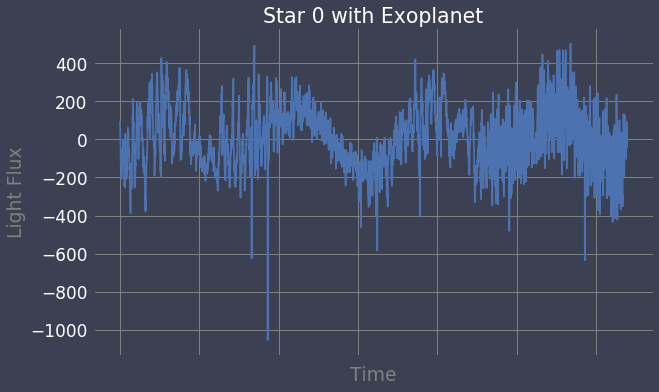

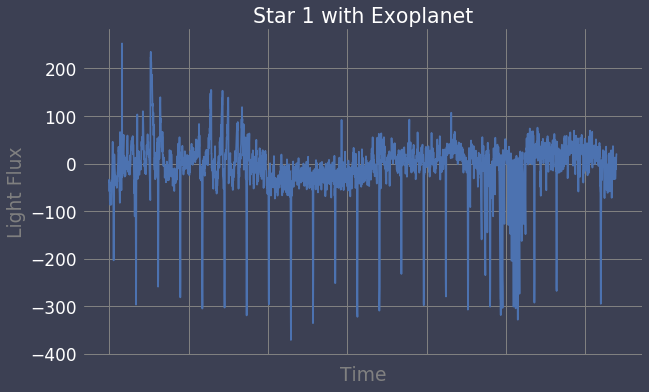

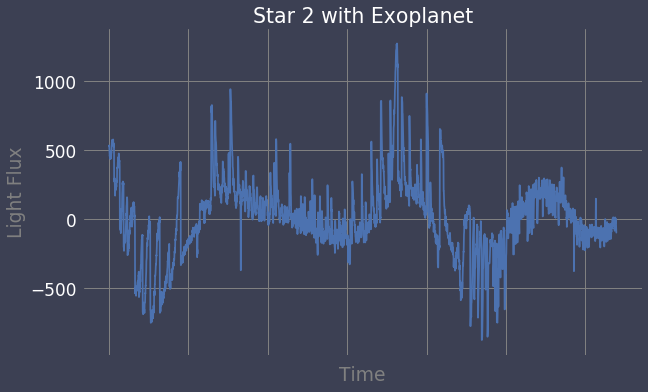

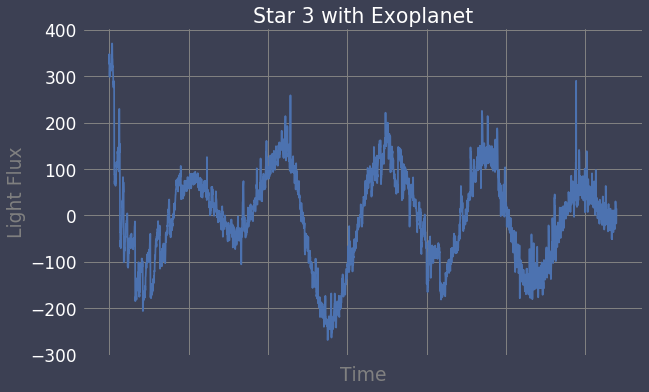

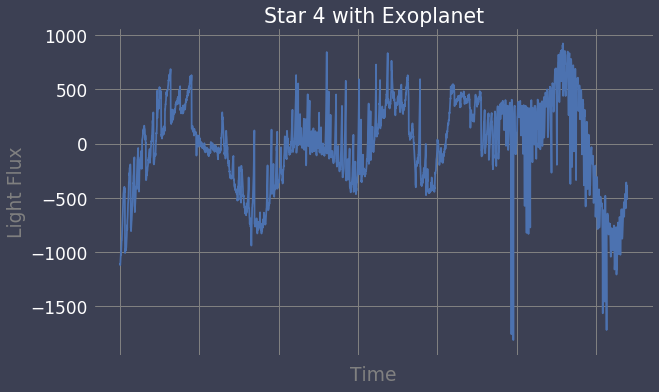

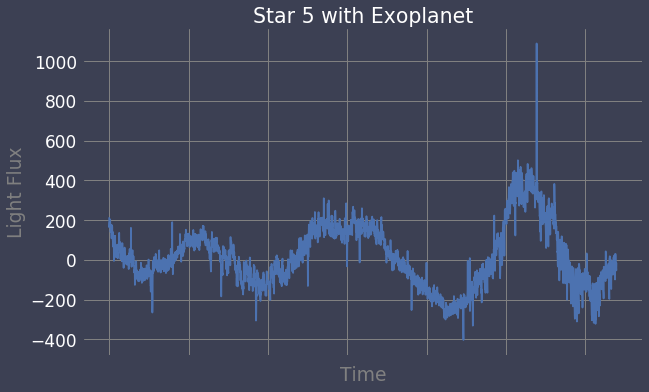

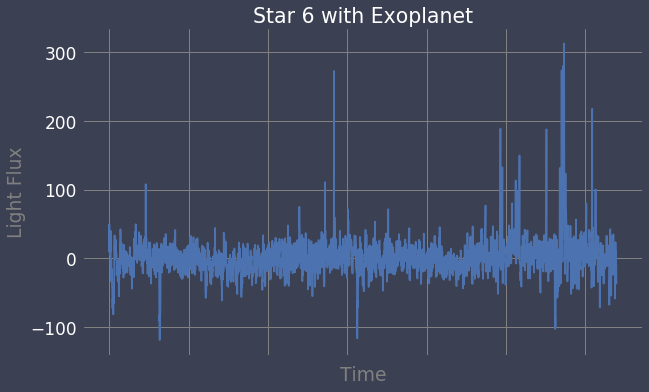

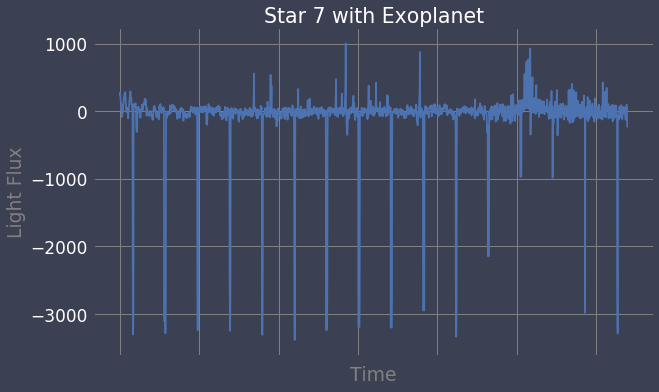

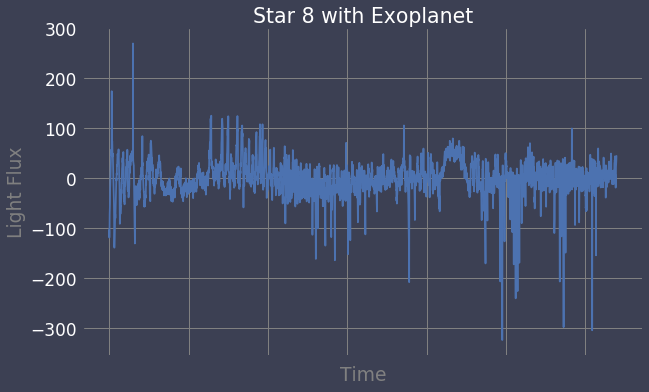

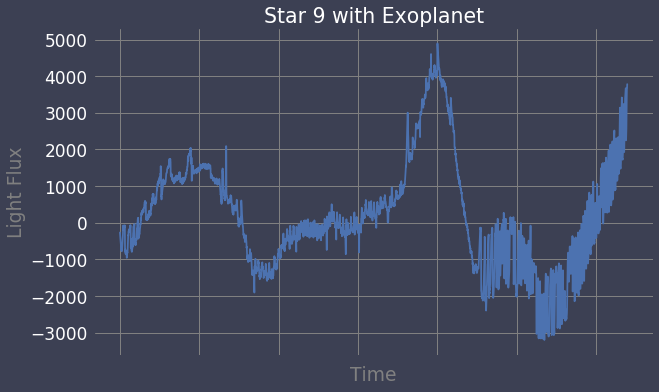

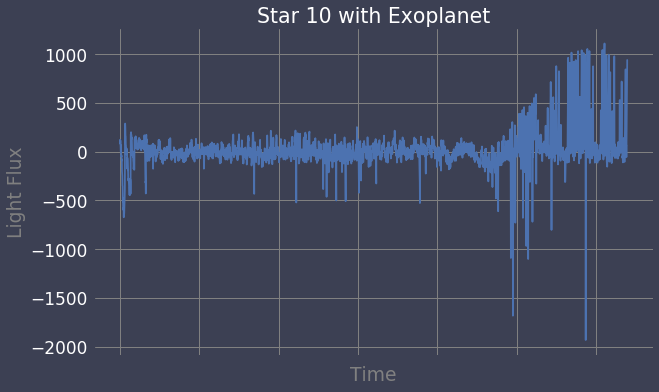

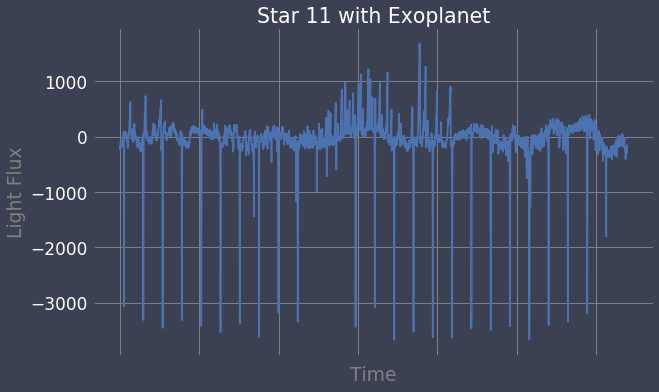

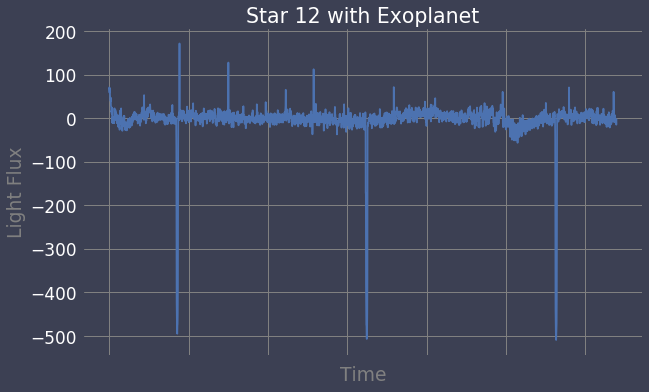

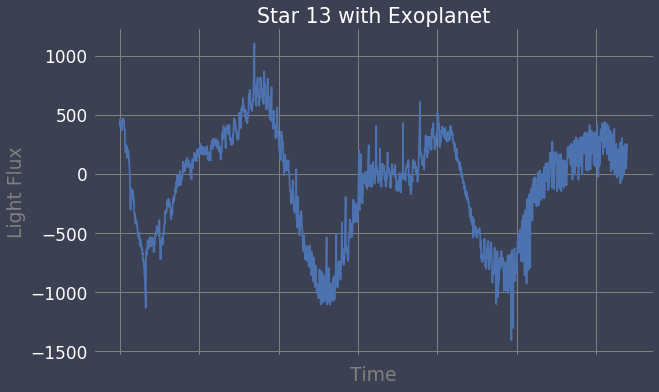

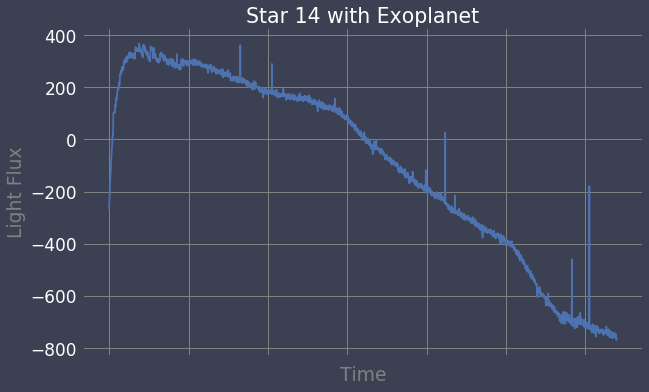

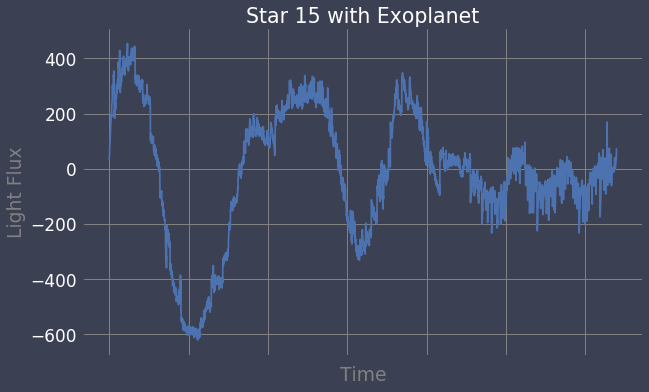

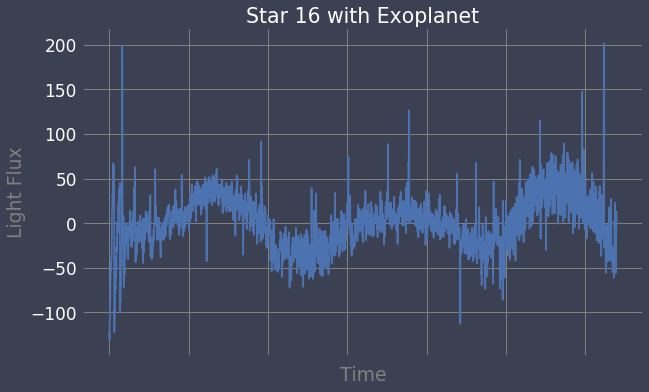

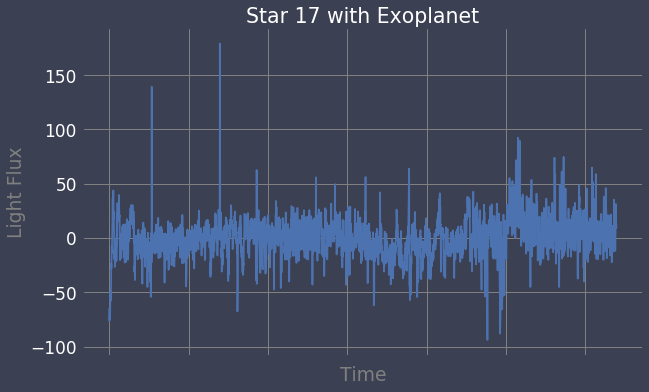

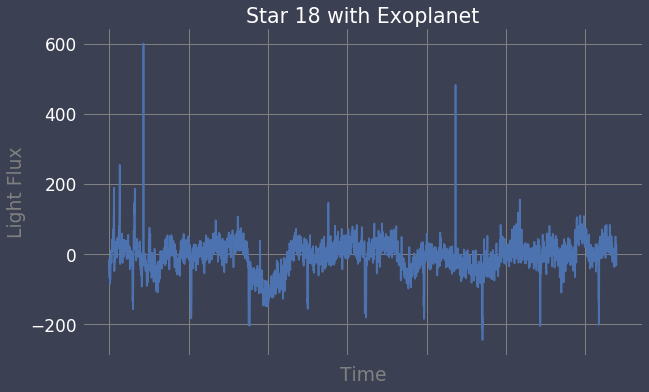

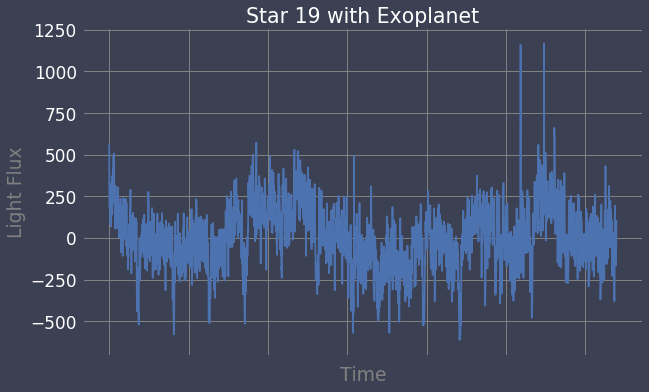

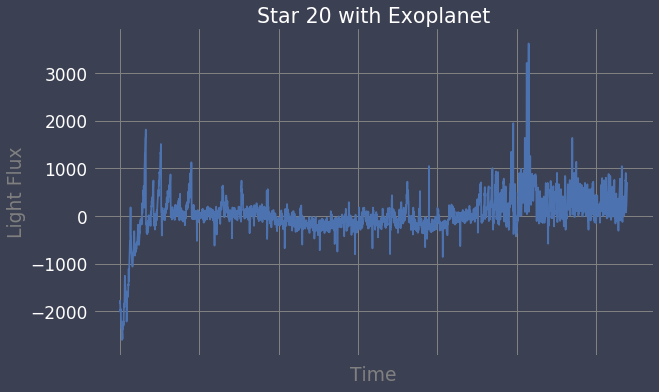

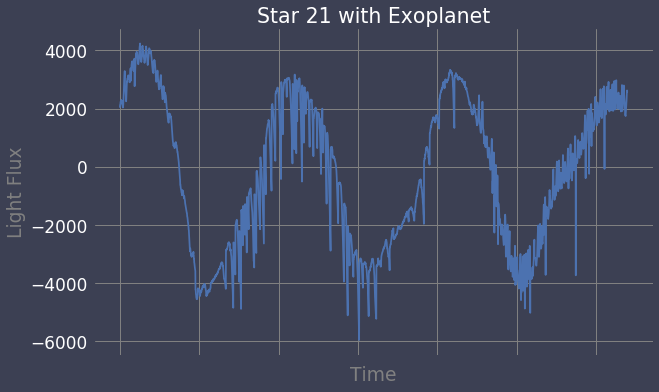

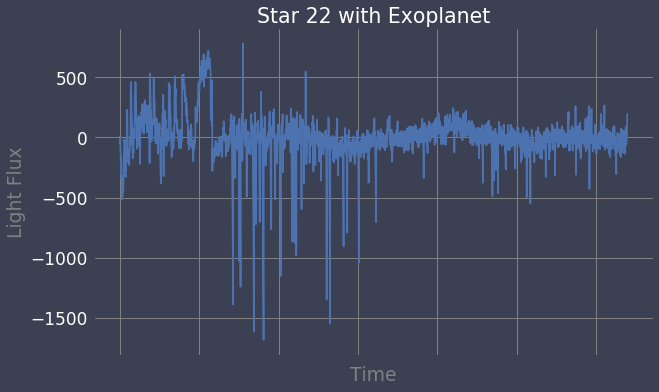

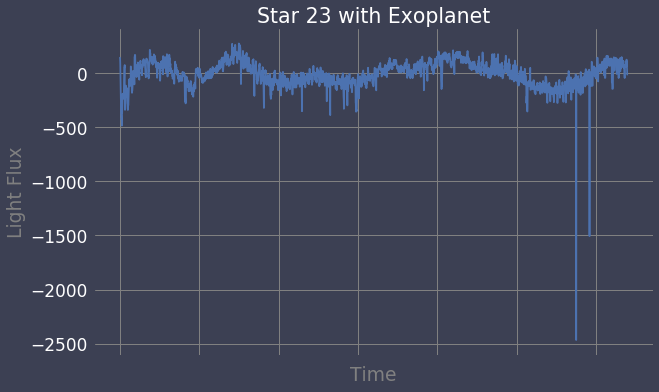

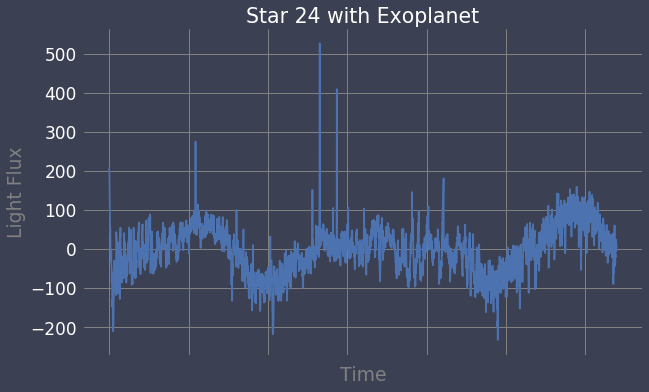

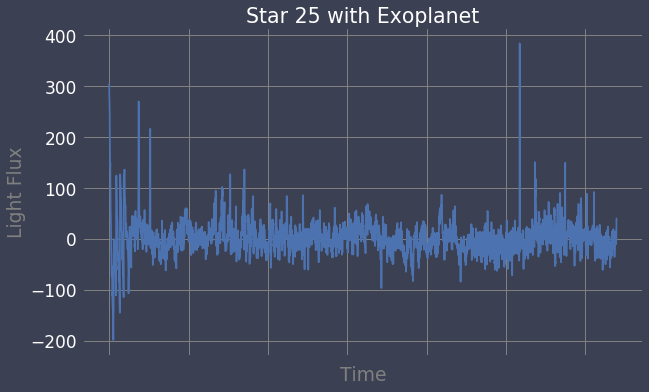

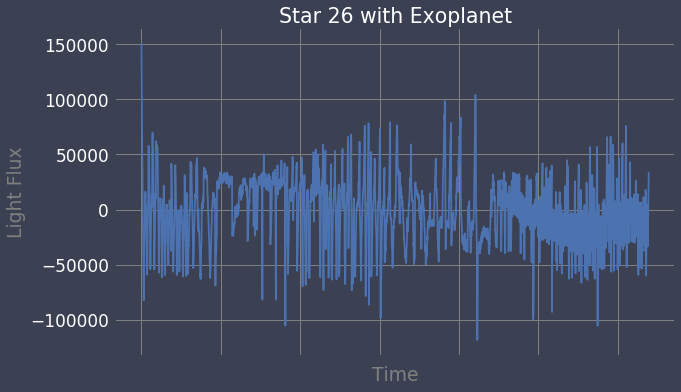

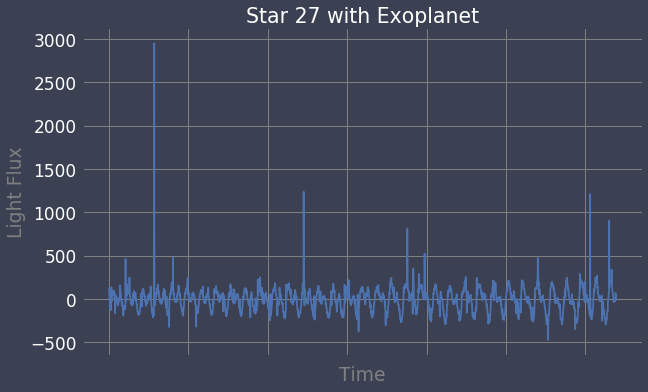

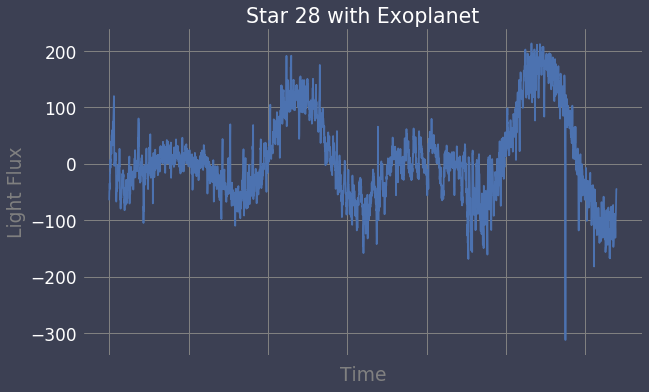

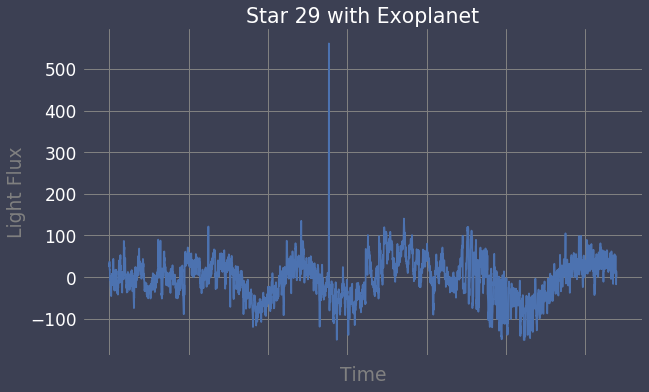

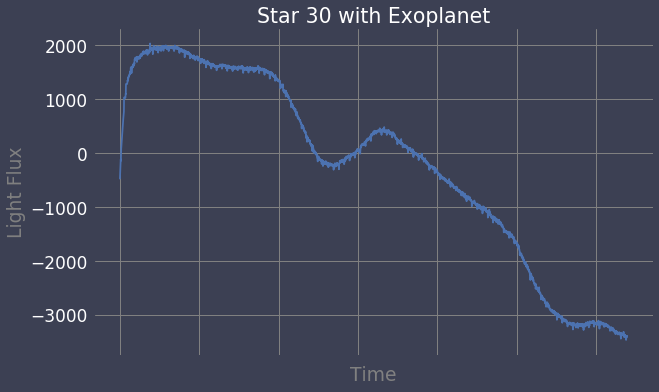

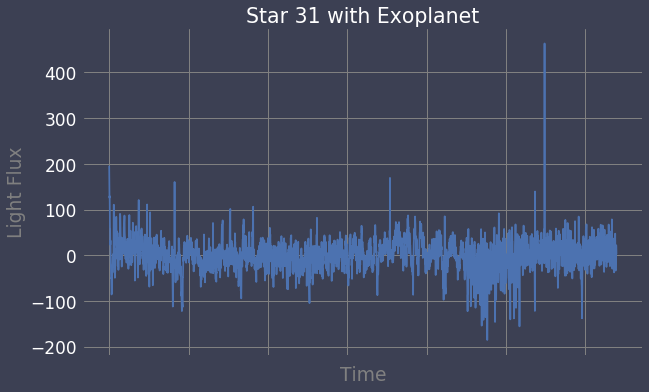

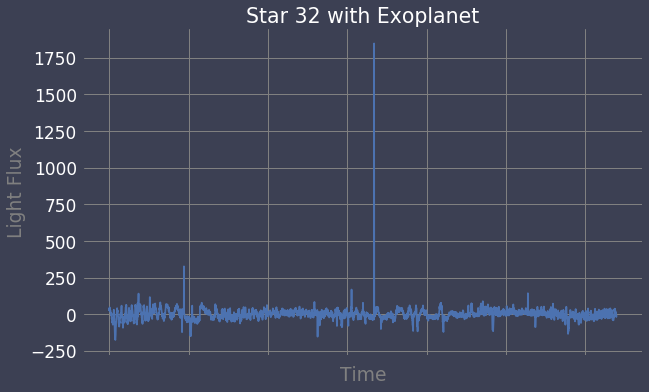

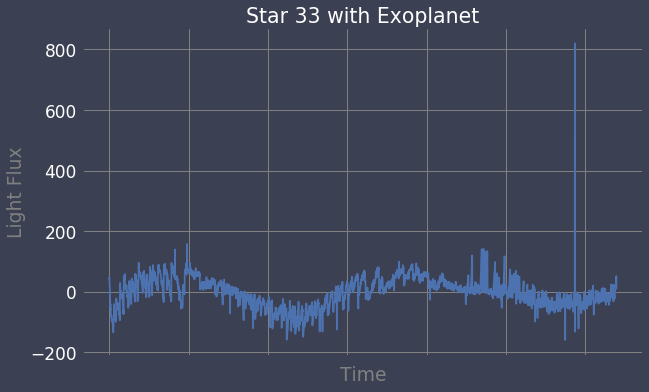

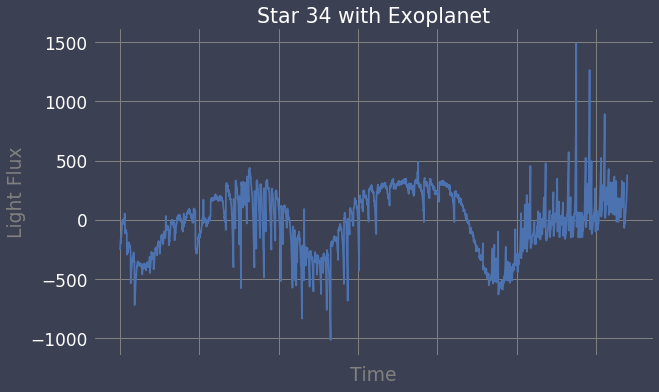

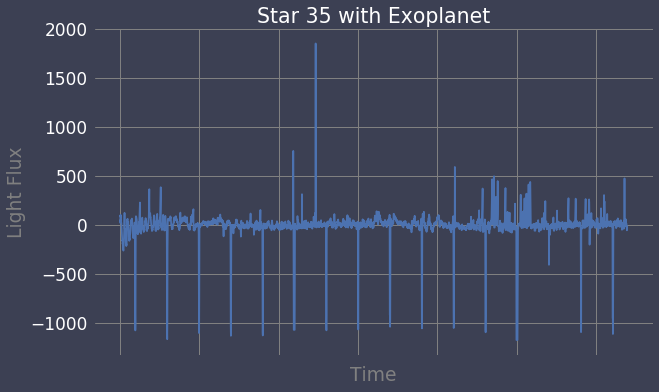

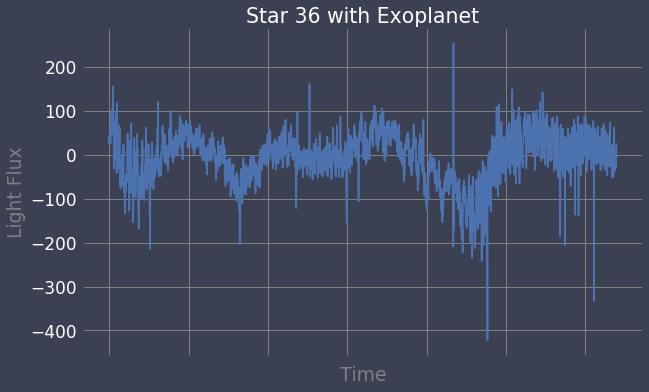

In [14]:
for i in range(exo1.shape[0]):
    exo1.iloc[i].plot(figsize=[10,6], title='Star {} with Exoplanet'.format(i))
    plt.xlabel('Time')
    plt.ylabel('Light Flux')
    plt.show()

Noisy data. Some plots follow a wave pattern. This is unusally. Was expecting plots like "Exoplanet 7". Looking to smooth the data and remove the wave pattern to prod